<h2>Titanic Analysis (HW2 Task 1) By Will Frazee</h2>
<h2>CAP5610</h2>
<p>Disclaimer: I did rework some of my preprocessing to better match the homework answers. For example, it wasn't entirely clear to me which preprocessing method we needed to use for age, and I chose a different one to use in HW1 than in the answers. For this assignment, I swapped my methods to better match the HW answers, because I want to ensure that my data fits as closely to what is expected as possible.</p>

In [91]:
#Importing everything I need
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn import tree
train_df = pd.read_csv('titanic/train.csv')
test_df = pd.read_csv('titanic/test.csv')

In [92]:
#I'm deleting the cabin column because over 75% of the data in that column is null, in both data sets.
test_df = test_df.drop(['Cabin'], axis=1)
train_df = train_df.drop(['Cabin'], axis=1)
#Dropping ticket
test_df = test_df.drop(['Ticket'], axis=1)
train_df = train_df.drop(['Ticket'], axis=1)
#Dropping name
train_df = train_df.drop(['Name'], axis=1)
test_df = test_df.drop(['Name'], axis=1)
#Dropping passenger id
train_df = train_df.drop(['PassengerId'], axis=1)
test_df = test_df.drop(['PassengerId'], axis=1)

In [93]:
#changing the sex column to a gender column, with numeric values instead of 'male' or 'female'
#testing data
test_df['Sex'] = np.where(test_df['Sex'] == 'male', 0, 1)
test_df.rename(columns={"Sex": "Gender"}, inplace=True)
test_df.astype({'Gender': 'int32'})
#training data
train_df['Sex'] = np.where(train_df['Sex'] == 'male', 0, 1)
train_df.rename(columns={"Sex": "Gender"}, inplace=True)
train_df.astype({'Gender': 'int32'})

,Survived,Pclass,Gender,Age,SibSp,Parch,Fare,Embarked
0,0,3,0,22.0,1,0,7.2500,S
1,1,1,1,38.0,1,0,71.2833,C
2,1,3,1,26.0,0,0,7.9250,S
3,1,1,1,35.0,1,0,53.1000,S
4,0,3,0,35.0,0,0,8.0500,S
...,...,...,...,...,...,...,...,...
886,0,2,0,27.0,0,0,13.0000,S
887,1,1,1,19.0,0,0,30.0000,S
888,0,3,1,NaN,1,2,23.4500,S
889,1,1,0,26.0,0,0,30.0000,C


In [94]:
#Filling in the missing age values
# Combines the 'Age' feature of the training and test sets to get the mean and 
# median
age_df = train_df['Age'].append(test_df['Age'])

# Gets the mean and median of the 'Age' feature of the combined data sets
mean = age_df.mean()
median = age_df.median()

print('Age Mean: ' + str(mean))
print('Age Median: ' + str(median))

# Sets the min and max range of the random number generator
if mean > median:
  min = median
  max = mean
else:
  min = mean
  max = median

# Fills in the null values of the 'Age' feature in the training and test sets
# with random values between the mean and median
for i in range(train_df.index.stop):
  if np.isnan(train_df.loc[i].at['Age']):
    train_df.at[i,'Age'] = np.random.uniform(min, max)

for i in range(test_df.index.stop):
  if np.isnan(test_df.loc[i].at['Age']):
    test_df.at[i,'Age'] = np.random.uniform(min, max)

Age Mean: 29.881137667304014
Age Median: 28.0


In [95]:
#Filling in the missing embarked values
# print(train_df.Embarked.describe())
# according to describe, 'S' is the most common value in Embarked
train_df.Embarked.fillna('S', inplace=True)
test_df.Embarked.fillna('S', inplace=True)

In [96]:
#Fill missing fare values with the mean value
test_df.Fare.fillna(test_df.Fare.mode()[0], inplace=True)
train_df.Fare.fillna(train_df.Fare.mode()[0], inplace=True)

In [97]:
#Categorize fare into discrete bins, following the specified fareband values

for i in range(train_df.index.stop):
    fare = train_df.loc[i].at['Fare']
    if fare > -0.001 and fare <= 7.91:
        train_df.at[i,'Fare'] = 0
    elif fare > 7.91 and fare <= 14.454:
        train_df.at[i,'Fare'] = 1
    elif fare > 14.454 and fare <= 31.0:
        train_df.at[i,'Fare'] = 2
    elif fare > 31.0 and fare <= 512.329:
        train_df.at[i,'Fare'] = 3
        
for i in range(test_df.index.stop):
    fare = test_df.loc[i].at['Fare']
    if fare > -0.001 and fare <= 7.91:
        test_df.at[i,'Fare'] = 0
    elif fare > 7.91 and fare <= 14.454:
        test_df.at[i,'Fare'] = 1
    elif fare > 14.454 and fare <= 31.0:
        test_df.at[i,'Fare'] = 2
    elif fare > 31.0 and fare <= 512.329:
        test_df.at[i,'Fare'] = 3

In [98]:
#Determining if I should drop parent/children number
print(train_df.groupby(['Parch', 'Survived']).count())
train_df = train_df.drop(['Parch'], axis=1)
test_df = test_df.drop(['Parch'], axis=1)

                Pclass  Gender  Age  SibSp  Fare  Embarked
Parch Survived                                            
0     0            445     445  445    445   445       445
      1            233     233  233    233   233       233
1     0             53      53   53     53    53        53
      1             65      65   65     65    65        65
2     0             40      40   40     40    40        40
      1             40      40   40     40    40        40
3     0              2       2    2      2     2         2
      1              3       3    3      3     3         3
4     0              4       4    4      4     4         4
5     0              4       4    4      4     4         4
      1              1       1    1      1     1         1
6     0              1       1    1      1     1         1


In [99]:
#Determining if I should drop sibling/spouse number
print(train_df.groupby(['SibSp', 'Survived']).count())
train_df = train_df.drop(['SibSp'], axis=1)
test_df = test_df.drop(['SibSp'], axis=1)

                Pclass  Gender  Age  Fare  Embarked
SibSp Survived                                     
0     0            398     398  398   398       398
      1            210     210  210   210       210
1     0             97      97   97    97        97
      1            112     112  112   112       112
2     0             15      15   15    15        15
      1             13      13   13    13        13
3     0             12      12   12    12        12
      1              4       4    4     4         4
4     0             15      15   15    15        15
      1              3       3    3     3         3
5     0              5       5    5     5         5
8     0              7       7    7     7         7


In [100]:
# Replace embarked with numbers
train_df['Embarked'].replace('C', 0, inplace=True)
train_df['Embarked'].replace('Q', 1, inplace=True)
train_df['Embarked'].replace('S', 2, inplace=True)

test_df['Embarked'].replace('C', 0, inplace=True)
test_df['Embarked'].replace('Q', 1, inplace=True)
test_df['Embarked'].replace('S', 2, inplace=True)

In [101]:
#Setting up the x and y train and test
x_train = train_df.copy(deep = True)
y_train = train_df.copy(deep = True)
x_train = x_train.drop(['Survived'], axis=1)
y_train = y_train.drop(['Pclass', 'Gender', "Age", 'Fare', 'Embarked'], axis=1)

x_test = test_df.copy(deep = True)
x_train.head(5)

,Pclass,Gender,Age,Fare,Embarked
0,3,0,22.0,0.0,2
1,1,1,38.0,3.0,0
2,3,1,26.0,1.0,2
3,1,1,35.0,3.0,2
4,3,0,35.0,1.0,2


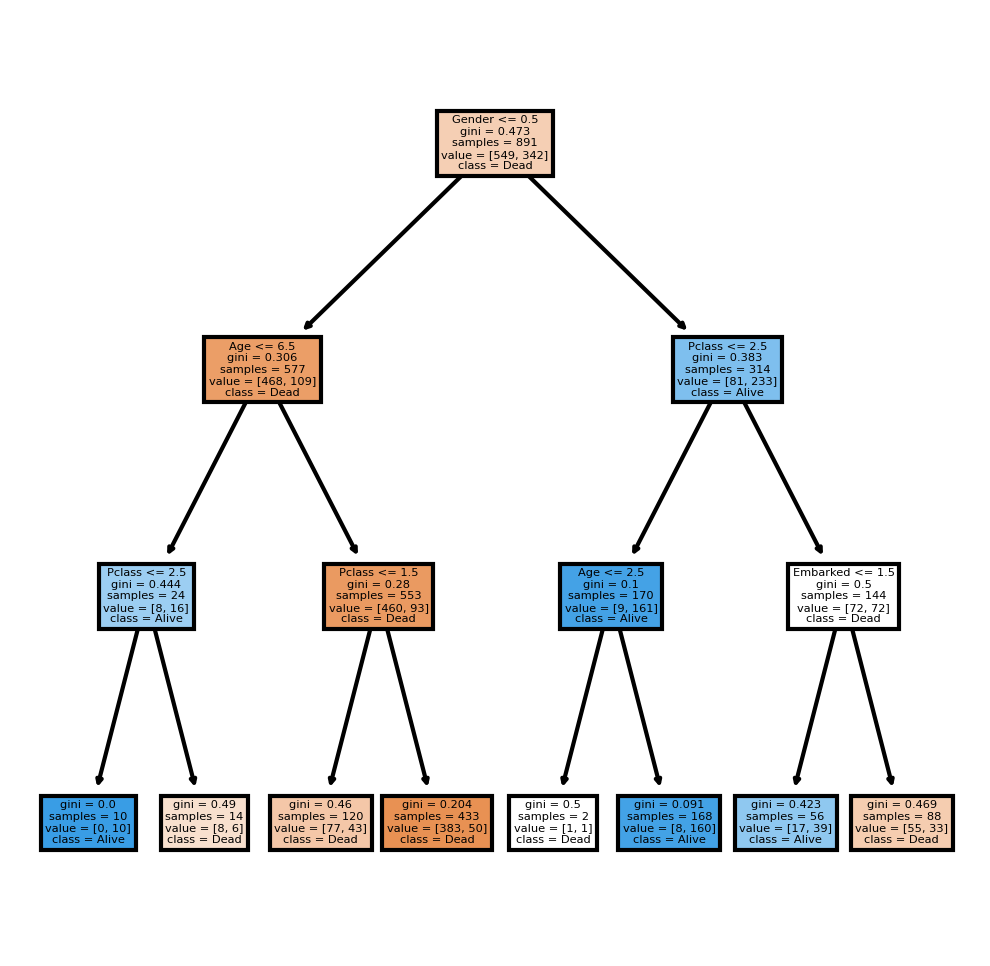

In [102]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(x_train, y_train)

fn=['Pclass', 'Gender', "Age", 'Fare', 'Embarked']
cn=['Dead', 'Alive']
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=300)
tree.plot_tree(clf,
               feature_names = fn, 
               class_names=cn,
               filled = True);

#tree.plot_tree(clf);

In [105]:
#Decision Tree Scores
scores = cross_val_score(clf, x_train, y_train, cv=5)
print(scores)

[0.77094972 0.79775281 0.79213483 0.78089888 0.82022472]


In [106]:
#Now use random forest
rf = RandomForestClassifier(n_estimators=100,
                            random_state=0)
rf.fit(x_train, y_train)